In this cycle we:

- We'll try to recover the 135080 customers id, that was previously null (it may contain valuable info)
- Studied different embedding spaces to us in our model
- Checked WSS and Silhouette scores 

# 1 IMPORTS

In [1]:
import re
import pandas as pd
import inflection
import seaborn as sns
import numpy as np
import umap.umap_ as umap
import sweetviz as sv


import matplotlib.cm as cm
from sklearn.neighbors import NearestNeighbors
from scipy.cluster import hierarchy as hc
from sklearn import mixture as mx
from sklearn import ensemble as en
from pandas_profiling import ProfileReport
from sklearn import manifold as mn
from sklearn import decomposition as dd
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp
from sklearn import cluster as c
from sklearn import metrics as m
from IPython.display import Image
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from plotly import express as px

## 1.1 Definitions 

In [2]:
# Set Seaborn configurations
sns.set_palette('tab10')
sns.set_style('darkgrid')

# Standard font for plots
def std_font(ax1, title, xlabel, ylabel):
    ax1.set_title(title, loc='left', fontdict={'fontsize': 18}, pad=20)
    ax1.set_xlabel(xlabel, fontdict={'fontsize': 12, 'style': 'italic'})
    ax1.set_ylabel(ylabel, fontdict={'fontsize': 12, 'style': 'italic'})
    return None

## 1.2 Loading Data

In [3]:
df_raw = pd.read_csv('../data/ecommerce.csv', parse_dates=['InvoiceDate'])
# Renaming columns
cols_snake = list( map( lambda x: inflection.underscore( x ), df_raw.columns ) )
df_raw.columns = cols_snake

# 2 DATA DESCRIPTION

## 2.1 Data Preview

In [4]:
df_raw.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850.0,United Kingdom


## 2.2 Data Format and Types

In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice_no    541909 non-null  object        
 1   stock_code    541909 non-null  object        
 2   description   540455 non-null  object        
 3   quantity      541909 non-null  int64         
 4   invoice_date  541909 non-null  datetime64[ns]
 5   unit_price    541909 non-null  float64       
 6   customer_id   406829 non-null  float64       
 7   country       541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


## 2.3 NA Checking and Treatment

In [6]:
df_raw.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

### 2.3.1 Treating Missing Values

In [7]:
# adding 'No description' to missing discription
df_raw['description'].fillna(value='NO DESCRIPTION', inplace=True)

# deleting NAs customer_id (this removed about 25% of our database)
# df_raw.dropna(subset=['customer_id'], inplace=True)

# creating customers_id
df_missing = df_raw.loc[df_raw['customer_id'].isna(), :]
df_not_missing = df_raw.loc[~df_raw['customer_id'].isna(), :]

df_backup = pd.DataFrame( df_missing['invoice_no'].drop_duplicates() )
df_backup['customer_id'] = np.arange( 19000, 19000+len( df_backup ), 1)

# merge original with reference dataframe
df_raw = pd.merge( df_raw, df_backup, on='invoice_no', how='left' )

# coalesce 
df_raw['customer_id'] = df_raw['customer_id_x'].combine_first( df_raw['customer_id_y'] )

# drop extra columns
df_raw = df_raw.drop( columns=['customer_id_x', 'customer_id_y'], axis=1 )



In [8]:
df_raw.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
country         0
customer_id     0
dtype: int64

## 2.4 Changing types

In [9]:
df_raw['customer_id'] = df_raw['customer_id'].astype( int )

## 2.5 Discriptive Statistics

In [10]:
df_clean = df_raw.copy()

### 2.5.1 Numerical Attributes

Important findings:

- We found a huge negative value in quantitiy (that can be due to product return, or cancelled purchase)
- We found a zero minimum price (what is the root cause of this? promotions? coupons?)
- We found a lot of negative values in quantity

In [11]:
num_att = df_clean.select_dtypes(['int64', 'float64', 'int'])

In [12]:
# getting skew
skew = pd.DataFrame(num_att.apply(lambda x: x.skew())).round(2).T
skew.rename(index={0: 'skew'}, inplace=True)

# getting kurtosis
kurtosis = pd.DataFrame(num_att.apply(lambda x: x.kurtosis())).round(2).T
kurtosis.rename(index={0: 'kurtosis'}, inplace=True)

# numerical features 
describe = num_att.describe().round(2)
ma = pd.concat([describe, skew, kurtosis], axis=0)
ma

,quantity,unit_price,customer_id
count,541909.00,541909.00,541909.00
mean,9.55,4.61,16688.84
std,218.08,96.76,2911.41
min,-80995.00,-11062.06,12346.00
25%,1.00,1.25,14367.00
50%,3.00,2.08,16249.00
75%,10.00,4.13,18283.00
max,80995.00,38970.00,22709.00
skew,-0.26,186.51,0.49
kurtosis,119769.16,59005.72,-0.80


### 2.5.2 Categorical Attributes

In [13]:
cat_att = df_clean.select_dtypes(['object'])

In [14]:
cat_att.apply( lambda x: x.unique().shape[0] )

invoice_no     25900
stock_code      4070
description     4224
country           38
dtype: int64

In [15]:
df_letter_invoices = df_clean.loc[df_clean['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), :]
df_letter_invoices.head()

print( 'Total number of invoices: {}'.format( len( df_letter_invoices ) ) )
print( 'Total number of negative quantity: {}'.format( len( df_letter_invoices[ df_letter_invoices['quantity'] < 0 ] ) ) )

Total number of invoices: 9291
Total number of negative quantity: 9288


# 3 DATAFRAME FILTERING

In [16]:
# =========================================================================================
# Check if its worth to treat the invoice_no and stock_code with letters in the values
# =========================================================================================

# # invoice_no
# df_letter_invoices = df1.loc[df1['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), :]
# df_letter_invoices.head()

# print( 'Total number of invoices: {}'.format( len( df_letter_invoices ) ) )
# print( 'Total number of negative quantity: {}'.format( len( df_letter_invoices[ df_letter_invoices['quantity'] < 0 ] ) ) )

# # stock_code
# # check stock codes only characters
# df1.loc[df1['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()


## 3.1 Line Filtering

In [17]:
# filtering zero values in unit_price (WE WILL CONSIDER THESE ITEMS AS PROMO OR ERROR)
df_clean.query('unit_price >= 0.04 ', inplace=True)

# bad users (apresentam padroes de compra bastante desconexo, poluindo nosso modelo)
df_clean = df_clean[~df_clean['customer_id'].isin( [16446] )]

# Considering negative quantities as devolutions and positive quantities as real purchases
df_clean_returns = df_clean.query('quantity < 0')
df_clean = df_clean.query('quantity >=0')

# removing stock codes that does not represent puchases
df_clean = df_clean[~df_clean['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'] )]

# removing innacurate country information 
df_clean = df_clean[~df_clean['country'].isin( ['European Community', 'Unspecified' ] ) ]

## 3.2 Column Selection

# 4 QUESTIONS & HYPOTHESIS

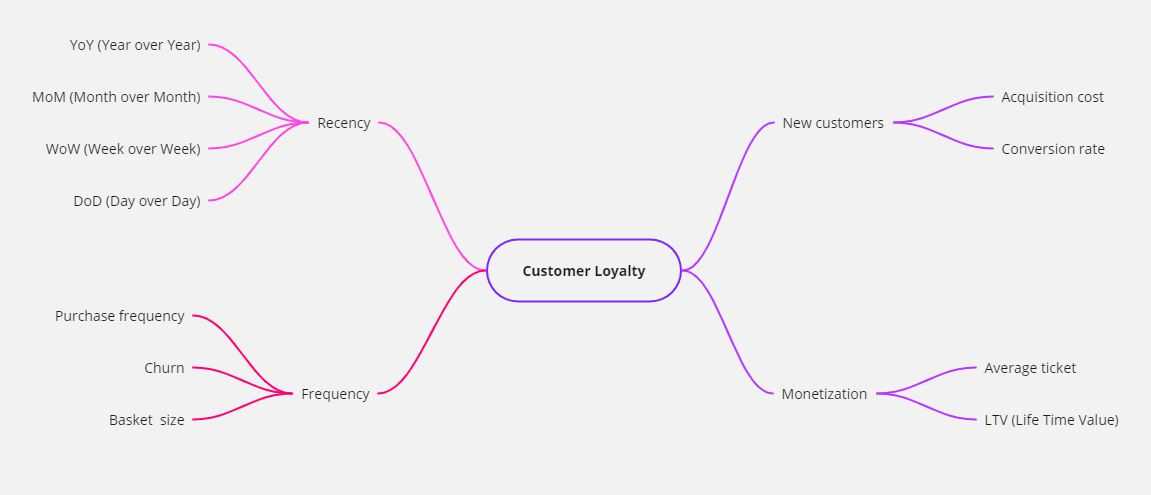

In [18]:
Image( '../images/mindmap.JPG' )

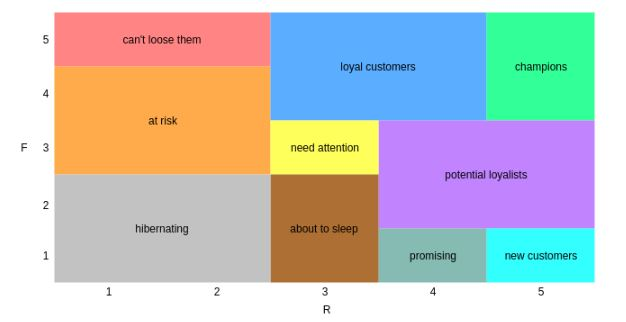

In [19]:
Image( '../images/rfm.JPG' )

Picture - https://medium.com/codex/crm-analytics-rfm-analysis-90aa2ae55fbc

# 5 FEATURE ENGINEERING

In [20]:
# ====================
# CREATING RFM TABLE
# ====================

# initiating df_rfm table with customers IDs
df_rfm = df_clean.drop( ['invoice_no', 'stock_code', 'description', 
                    'quantity', 'invoice_date', 'unit_price', 
                    'country'], axis=1 ).drop_duplicates( ignore_index=True )

In [21]:
# monetary
df_clean['gross_revenue'] = df_clean['quantity'] * df_clean['unit_price']
df_monetary = df_clean[['customer_id', 'gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
df_rfm = pd.merge( df_rfm, df_monetary, on='customer_id', how='left' )


In [22]:
# recency - last purchase
df_recency = df_clean[['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df_clean['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_rfm = pd.merge( df_rfm, df_recency, on='customer_id', how='left' )

In [23]:
# amount of purchases
df_freq = df_clean[['customer_id', 'invoice_no']].drop_duplicates().groupby( 'customer_id' ).count().reset_index().rename( columns={'invoice_no': 'amount_invoices'})
df_rfm = pd.merge( df_rfm, df_freq, on='customer_id', how='left' )

In [24]:
# amount of purchased items
df_prod = df_clean[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity': 'amount_items'})
df_rfm = pd.merge( df_rfm, df_prod, on='customer_id', how='left' )


In [25]:
# amount of purchased products
# Numero de produtos
df_freq = (df_clean.loc[:, ['customer_id', 'stock_code']].groupby( 'customer_id' ).count()
                                                           .reset_index()
                                                           .rename( columns={'stock_code': 'amount_products'} ) )
df_rfm = pd.merge( df_rfm, df_freq, on='customer_id', how='left' )


In [26]:
# average ticket
df_avg_ticket = df_clean[['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue':'avg_ticket'} )
df_rfm = pd.merge( df_rfm, df_avg_ticket, on='customer_id', how='left')

In [27]:
# number of returns
df_number_returns = df_clean_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'amount_returns'})
df_number_returns['amount_returns'] = df_number_returns['amount_returns'] * -1
df_rfm = pd.merge( df_rfm, df_number_returns, on='customer_id', how='left')
df_rfm.loc[df_rfm['amount_returns'].isna(), 'amount_returns'] = 0
# df_rfm['amount_returns'].fillna(value=0, inplace=True)

In [28]:
# Average recency days
df_aux = df_clean[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'], ascending=[False, False] )
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoince date
df_aux['avg_recency_days'] = df_aux.apply( lambda x: ( x['invoice_date'] - x['previous_date'] ).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1 )
df_aux = df_aux.drop( ['invoice_date', 'next_customer_id', 'previous_date'], axis=1 ).dropna()

df_avg_recency_days = df_aux.groupby( 'customer_id' ).mean().reset_index()

df_rfm = pd.merge( df_rfm, df_avg_recency_days, on='customer_id', how='left' )


In [29]:
# frequency purchase 
df_aux = ( df_clean[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                             .groupby( 'customer_id')
                                                             .agg( max_ = ( 'invoice_date', 'max' ), 
                                                                   min_ = ( 'invoice_date', 'min' ),
                                                                   days_= ( 'invoice_date', lambda x: ( ( x.max() - x.min() ).days ) + 1 ),
                                                                   buy_ = ( 'invoice_no', 'count' ) ) ).reset_index()

df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if  x['days_'] != 0 else 0, axis=1 )
df_rfm = pd.merge( df_rfm, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )

In [30]:
# basket size (Units by basket)
df_aux = ( df_clean.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                  n_products=( 'quantity', 'sum' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_rfm = pd.merge( df_rfm, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id' )

In [31]:
df_aux = ( df_clean.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                   n_products=( 'stock_code', 'nunique' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_rfm = pd.merge( df_rfm, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id' )

In [32]:
df_rfm.isna().sum()

customer_id                  0
gross_revenue                0
recency_days                 0
amount_invoices              0
amount_items                 0
amount_products              0
avg_ticket                   0
amount_returns               0
avg_recency_days          2922
frequency                    0
avg_basket_size              0
avg_unique_basket_size       0
dtype: int64

In [33]:
df_rfm.head()

,customer_id,gross_revenue,recency_days,amount_invoices,amount_items,amount_products,avg_ticket,amount_returns,avg_recency_days,frequency,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372,34,1733,297,18.152222,40.0,-1.000000,17.000000,50.970588,0.617647
1,13047,3232.59,56,9,1390,171,18.904035,36.0,-52.833333,0.028302,154.444444,11.666667
2,12583,6705.38,2,15,5028,232,28.902500,51.0,-26.500000,0.040323,335.200000,7.600000
3,13748,948.25,95,5,439,28,33.866071,0.0,-92.666667,0.017921,87.800000,4.800000
4,15100,876.00,333,3,80,3,292.000000,22.0,-20.000000,0.073171,26.666667,0.333333


# 6 EXPLORATORY DATA ANALYSIS

In [34]:
df_rfm.dropna(inplace=True)

## 6.1 Univariate Analysis

In [35]:
profile = ProfileReport( df_rfm )
profile.to_file( 'profile_report.html' )

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [36]:
# report = sv.analyze(df_rfm)
# report.show_html('sweetviz_report.html')

### 6.1.1 Response Variable

### 6.1.2 Numerical Variable

### 6.1.3 Categorical Variable

## 6.2 Bivariate Analysis

## 6.3 Multivariate Analysis


### 6.3.1 Numerical Attributes

### 6.3.2 Categorical Attributes

# 7 DATA PREPARATION

## 7.1 Normalization

In [37]:
## Standard Scalaer
mm = pp.MinMaxScaler()

# df_rfm['gross_revenue'] = ss.fit_transform( df_rfm[['gross_revenue']] )
# df_rfm['recency_days'] = ss.fit_transform( df_rfm[['recency_days']] )
# # df_rfm['invoice_no'] = ss.fit_transform( df_rfm[['invoice_no']] )
# df_rfm['avg_ticket'] = ss.fit_transform( df_rfm[['avg_ticket']] )
# # df_rfm['returns'] = ss.fit_transform( df_rfm[['returns']] )

df_rfm['gross_revenue'] = mm.fit_transform( df_rfm[['gross_revenue']] )
df_rfm['recency_days']           = mm.fit_transform( df_rfm[['recency_days']] )
df_rfm['amount_invoices']          = mm.fit_transform( df_rfm[['amount_invoices']])
df_rfm['amount_items']             = mm.fit_transform( df_rfm[['amount_items']])
df_rfm['amount_products']          = mm.fit_transform( df_rfm[['amount_products']])
df_rfm['avg_ticket']             = mm.fit_transform( df_rfm[['avg_ticket']])
df_rfm['avg_recency_days']       = mm.fit_transform( df_rfm[['avg_recency_days']])
df_rfm['frequency']              = mm.fit_transform( df_rfm[['frequency']])
df_rfm['amount_returns']           = mm.fit_transform( df_rfm[['amount_returns']])
df_rfm['avg_basket_size']        = mm.fit_transform( df_rfm[['avg_basket_size']])
df_rfm['avg_unique_basket_size'] = mm.fit_transform( df_rfm[['avg_unique_basket_size']] )

In [38]:
X = df_rfm.drop(columns=['customer_id']).copy()
X.head()

,gross_revenue,recency_days,amount_invoices,amount_items,amount_products,avg_ticket,amount_returns,avg_recency_days,frequency,avg_basket_size,avg_unique_basket_size
0,0.019185,1.000000,0.156863,0.008794,0.037647,0.003595,0.004438,1.000000,1.000000,0.008317,0.002362
1,0.011451,0.150538,0.034314,0.007051,0.021567,0.003764,0.003994,0.857991,0.001345,0.025539,0.064857
2,0.023894,0.005376,0.063725,0.025533,0.029352,0.006010,0.005658,0.930137,0.002052,0.055623,0.041855
3,0.003267,0.255376,0.014706,0.002220,0.003318,0.007125,0.000000,0.748858,0.000734,0.014447,0.026018
4,0.003008,0.895161,0.004902,0.000396,0.000128,0.065116,0.002441,0.947945,0.003985,0.004272,0.000754


## 7.2 Rescaling

## 7.3 Transformation

### 7.3.1 Encoding

## 7.4 Space Study

### 7.4.1 PCA

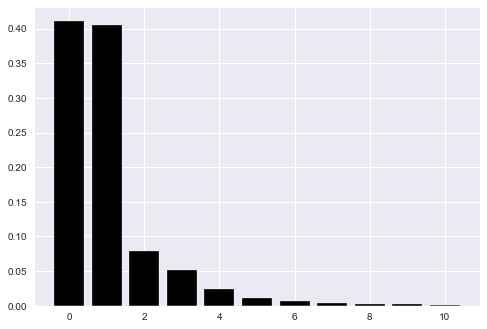

In [39]:
pca = dd.PCA( n_components=X.shape[1] )

principal_components = pca.fit_transform( X )

# plot explained variable
features = range( pca.n_components_ )

plt.bar( features, pca.explained_variance_ratio_, color='black' )

# pca component
df_pca = pd.DataFrame( principal_components )

<AxesSubplot:xlabel='0', ylabel='1'>

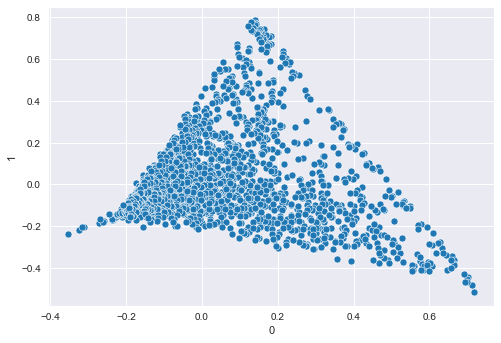

In [40]:
sns.scatterplot( x=0, y=1, data=df_pca )

### 7.4.2 UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

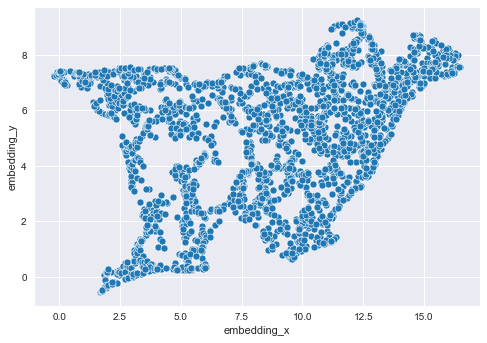

In [41]:
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_pca )

### 7.4.3 t-SNE

C:\Users\Rodrigo\anaconda3\envs\env_portfolio\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Rodrigo\anaconda3\envs\env_portfolio\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

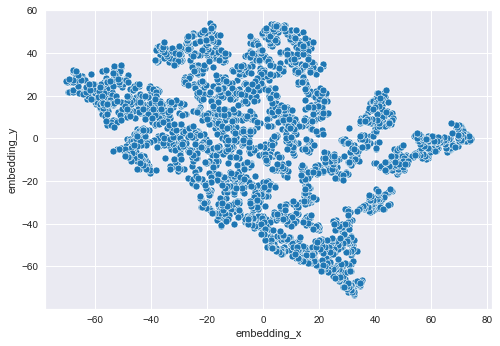

In [42]:
reducer = mn.TSNE( n_components=2, n_jobs=-1, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_pca )

### 7.4.4 TREE Based Embedding

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

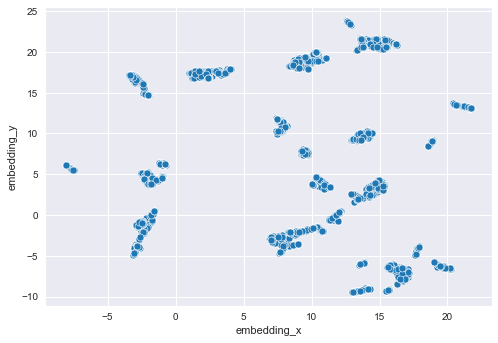

In [43]:
# training dataset
X = df_rfm.drop( columns=['customer_id', 'gross_revenue'], axis=1 )
y = df_rfm['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42 )

# model training
rf_model.fit( X, y )

# Leaf 

# dataframe Leaf

df_leaf = pd.DataFrame( rf_model.apply( X ) )

# Reduzer dimensionality
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_pca )

# 8 FEATURE SELECTION

# 9 HYPERPARAMETER FINE TUNNING

In [44]:
clusters = [2, 3, 4, 5, 6, 7]
X = df_rfm.drop( columns=['customer_id'] )

## 9.1 Elbow and WSS

C:\Users\Rodrigo\anaconda3\envs\env_portfolio\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(
C:\Users\Rodrigo\anaconda3\envs\env_portfolio\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(
C:\Users\Rodrigo\anaconda3\envs\env_portfolio\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(
C:\Users\Rodrigo\anaconda3\envs\env_portfolio\lib\site-packages\sklear

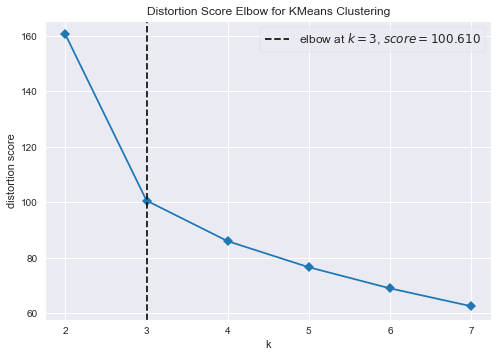

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [45]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, timings=False )
kmeans.fit( X )
kmeans.show()

C:\Users\Rodrigo\anaconda3\envs\env_portfolio\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(
C:\Users\Rodrigo\anaconda3\envs\env_portfolio\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(
C:\Users\Rodrigo\anaconda3\envs\env_portfolio\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(
C:\Users\Rodrigo\anaconda3\envs\env_portfolio\lib\site-packages\sklear

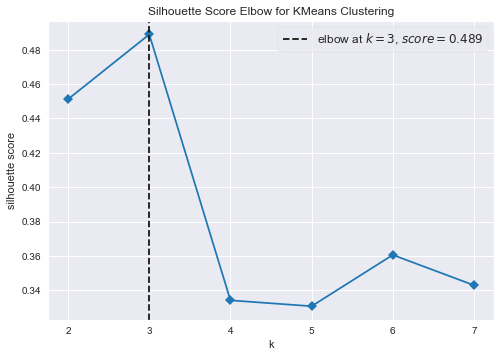

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [46]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, metric='silhouette', timings=False )
kmeans.fit( X )
kmeans.show()

C:\Users\Rodrigo\anaconda3\envs\env_portfolio\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(
C:\Users\Rodrigo\anaconda3\envs\env_portfolio\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(
C:\Users\Rodrigo\anaconda3\envs\env_portfolio\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(
C:\Users\Rodrigo\anaconda3\envs\env_portfolio\lib\site-packages\sklear

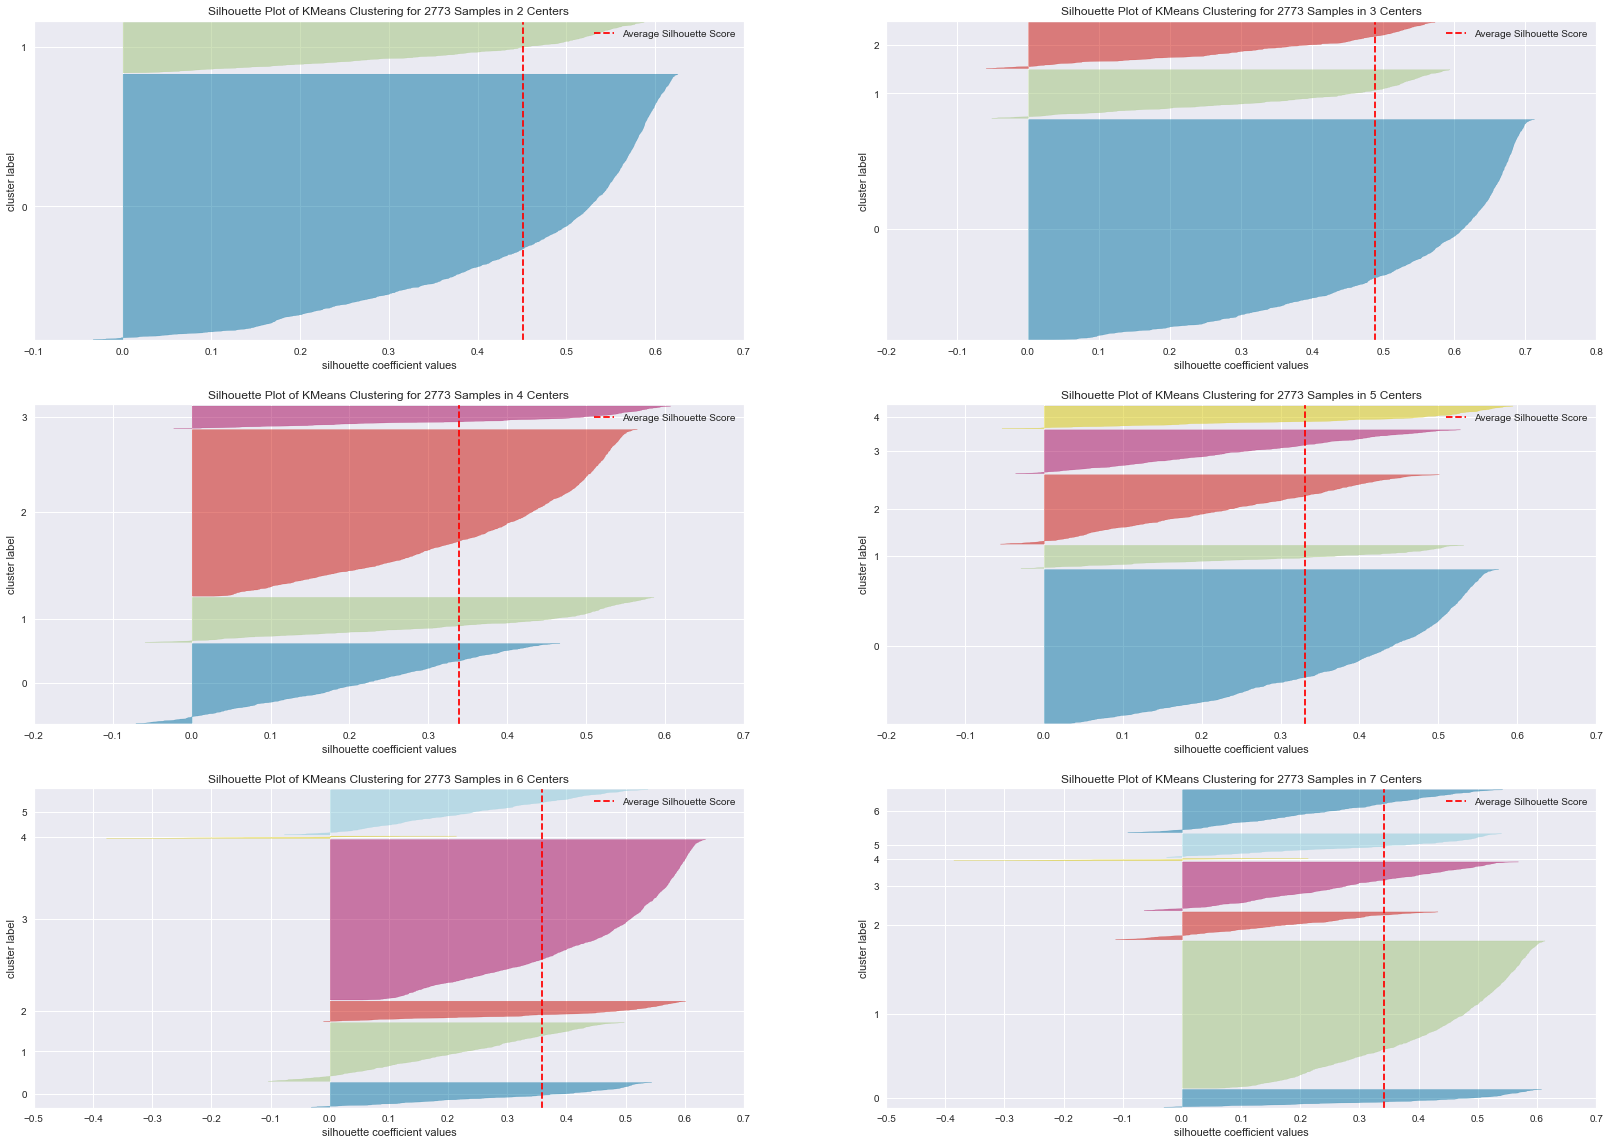

In [47]:
fig, ax = plt.subplots( 3, 2, figsize=(28, 20) )

for k in clusters:
    km = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42 )
    q, mod = divmod( k, 2 )
    
    visualizer = SilhouetteVisualizer( km, colors='yellowbrick', ax=ax[q-1][mod] )
    visualizer.fit( X )
    visualizer.finalize()

In [48]:
kmeans = c.KMeans(init='random', n_clusters=3, n_init=10, max_iter=300, random_state=42) 
kmeans.fit(X)
labels = kmeans.labels_

C:\Users\Rodrigo\anaconda3\envs\env_portfolio\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(


In [49]:
## WSS ( Within-cluster sum of square)
print( 'WSS value: {}'.format( kmeans.inertia_ ) )

## SS ( Silhouette Score )
print( 'SS value: {}'.format( m.silhouette_score( X, labels, metric='euclidean' ) ) )

WSS value: 100.60984542745759
SS value: 0.48890011782657555


In [50]:
df_rfm['cluster'] = labels
df_rfm.head()

,customer_id,gross_revenue,recency_days,amount_invoices,amount_items,amount_products,avg_ticket,amount_returns,avg_recency_days,frequency,avg_basket_size,avg_unique_basket_size,cluster
0,17850,0.019185,1.000000,0.156863,0.008794,0.037647,0.003595,0.004438,1.000000,1.000000,0.008317,0.002362,1
1,13047,0.011451,0.150538,0.034314,0.007051,0.021567,0.003764,0.003994,0.857991,0.001345,0.025539,0.064857,0
2,12583,0.023894,0.005376,0.063725,0.025533,0.029352,0.006010,0.005658,0.930137,0.002052,0.055623,0.041855,0
3,13748,0.003267,0.255376,0.014706,0.002220,0.003318,0.007125,0.000000,0.748858,0.000734,0.014447,0.026018,0
4,15100,0.003008,0.895161,0.004902,0.000396,0.000128,0.065116,0.002441,0.947945,0.003985,0.004272,0.000754,1


### 9.1.1 Silhouette Visualization

In [51]:
df_viz = df_rfm.drop(columns='customer_id')

C:\Users\Rodrigo\anaconda3\envs\env_portfolio\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


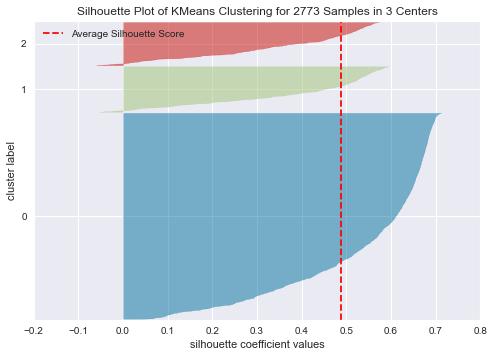

In [52]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

### 9.1.1 Pairplot Visualization

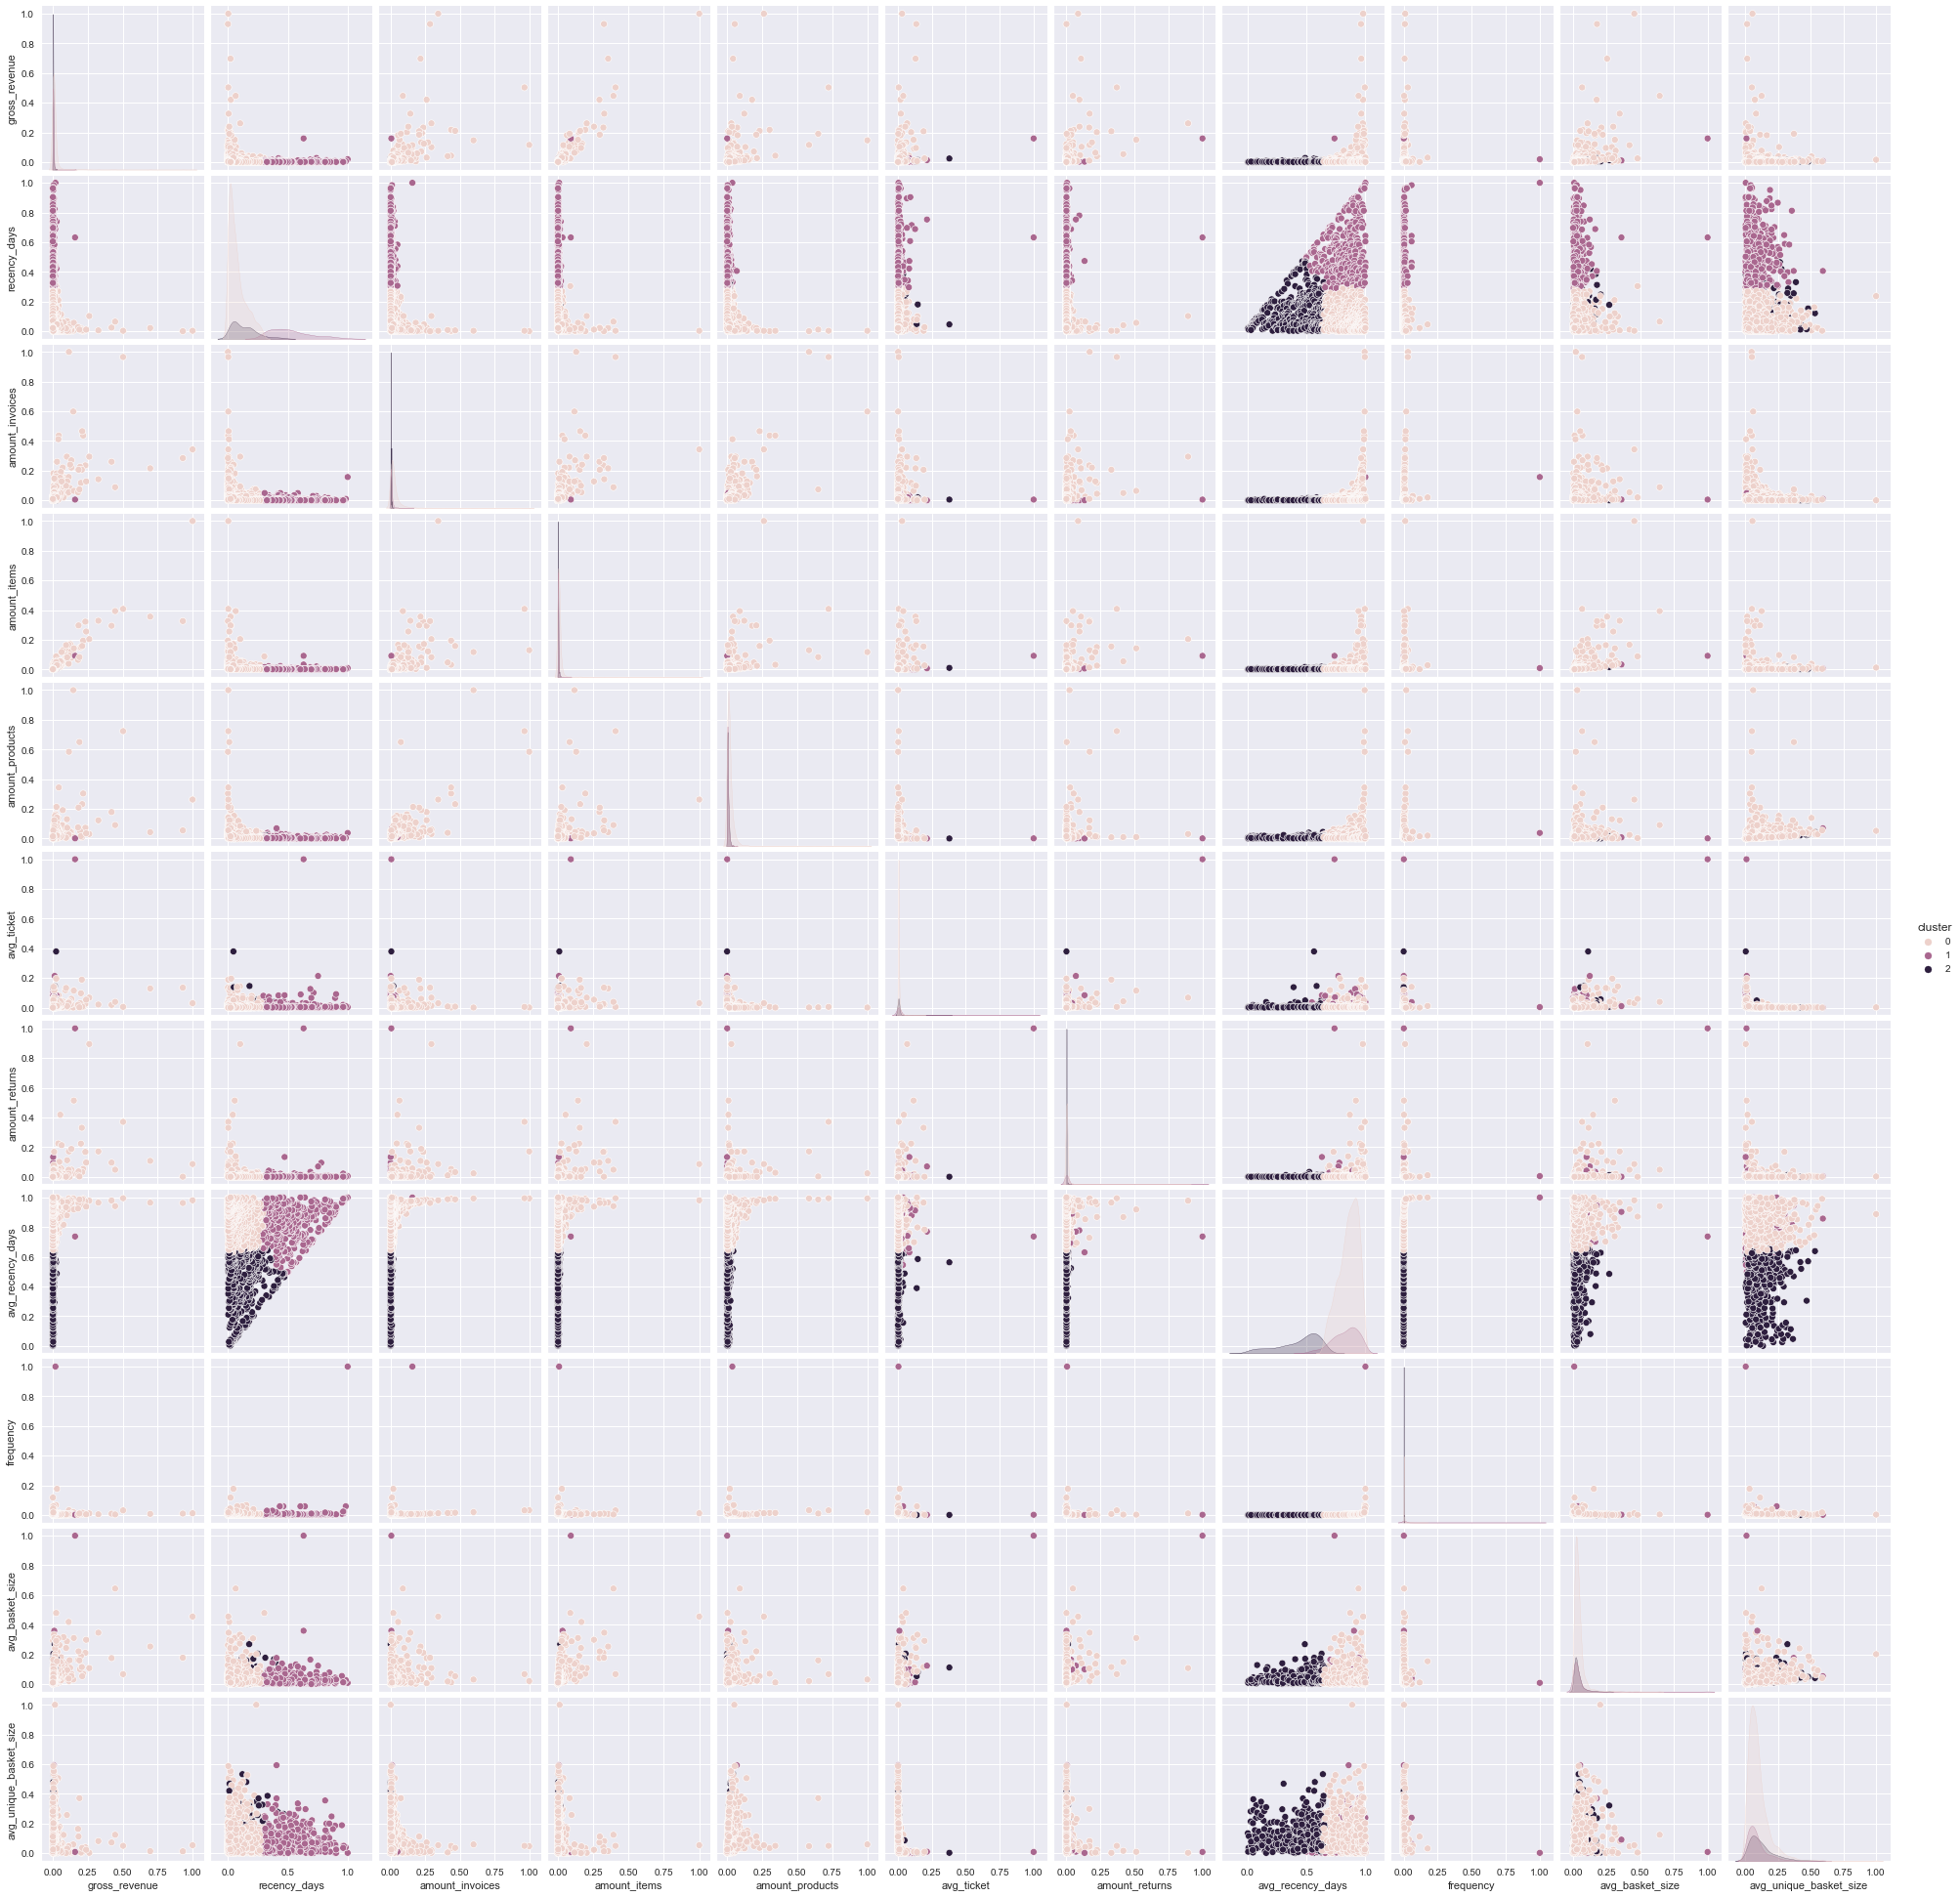

In [53]:
sns.pairplot(df_viz, hue='cluster')

### 9.1.1 UMAP 

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

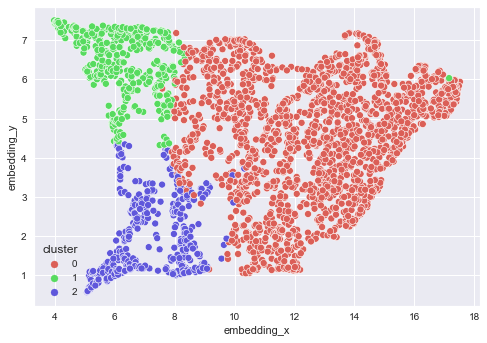

In [54]:
reducer = umap.UMAP( n_neighbors=50, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y', 
                 hue='cluster', 
                 palette=sns.color_palette( 'hls', n_colors=len( df_viz['cluster'].unique() ) ),
                 data=df_viz )

### 9.1.2 Clusters Info

In [55]:
# Number of customer
df_cluster = df_rfm[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross revenue
df_avg_gross_revenue = df_rfm[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# Avg recency days
df_avg_recency_days = df_rfm[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster' )

# Avg invoice_no
df_invoice_no = df_rfm[['amount_invoices', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_invoice_no, how='inner', on='cluster' )

# # Avg Ticket
# df_ticket = df_rfm[['avg_ticket', 'cluster']].groupby( 'cluster' ).mean().reset_index()
# df_cluster = pd.merge( df_cluster, df_ticket, how='inner', on='cluster' )

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,amount_invoices
0,0,1938,69.888208,0.013007,0.076248,0.026961
1,1,428,15.434547,0.003572,0.516399,0.005097
2,2,407,14.677245,0.002867,0.131397,0.001686


## 9.1 KMEANS

In [56]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans( n_clusters=k )

    # model training
    kmeans_model.fit( X )

    # model predict
    labels = kmeans_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    kmeans_list.append( sil )

C:\Users\Rodrigo\anaconda3\envs\env_portfolio\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(
C:\Users\Rodrigo\anaconda3\envs\env_portfolio\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(
C:\Users\Rodrigo\anaconda3\envs\env_portfolio\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(
C:\Users\Rodrigo\anaconda3\envs\env_portfolio\lib\site-packages\sklear

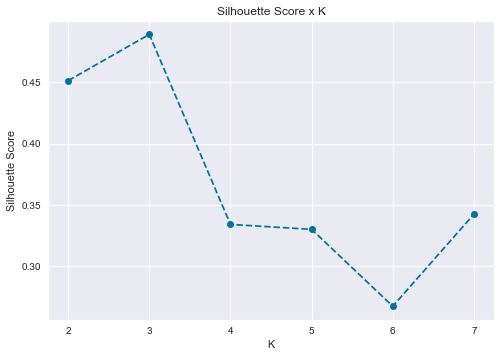

In [57]:
plt.plot( clusters, kmeans_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score' );
plt.title( 'Silhouette Score x K' );

## 9.2 GMM

In [58]:
# AIC - Ajuste dos dados
# BIC - ajuste dos parametros

gmm_list = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture( n_components=k )

    # model training
    gmm_model.fit( X )

    # model predict
    labels = gmm_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    gmm_list.append( sil )

C:\Users\Rodrigo\anaconda3\envs\env_portfolio\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(
C:\Users\Rodrigo\anaconda3\envs\env_portfolio\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(
C:\Users\Rodrigo\anaconda3\envs\env_portfolio\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(
C:\Users\Rodrigo\anaconda3\envs\env_portfolio\lib\site-packages\sklear

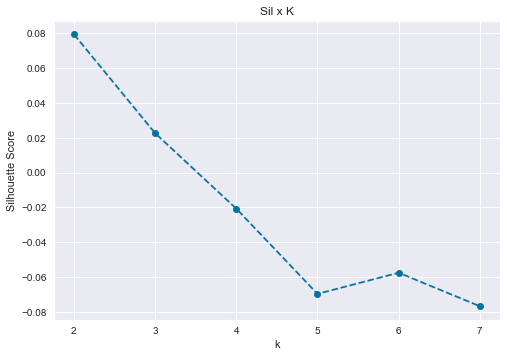

In [59]:
plt.plot( clusters, gmm_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'k');
plt.ylabel( 'Silhouette Score');
plt.title( 'Sil x K');

## 9.3 Hierarchical Clustering

[]

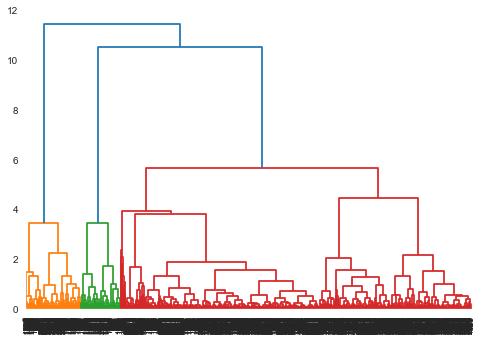

In [60]:
# model definition and training
hc_model = hc.linkage( X, 'ward' )

hc.dendrogram( 
    hc_model, 
    leaf_rotation=90,
    leaf_font_size=8
)

plt.plot()

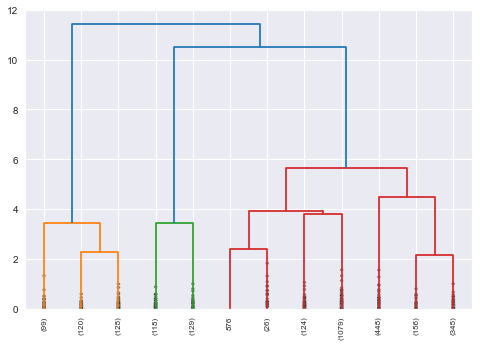

In [61]:
hc.dendrogram( 
    hc_model,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90,
    leaf_font_size=8,
    show_contracted=True
)

plt.show()

### 9.3.1 HC Silhouette Score

In [62]:
hc_list = []
for k in clusters:
    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # metrics
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    hc_list.append( sil )

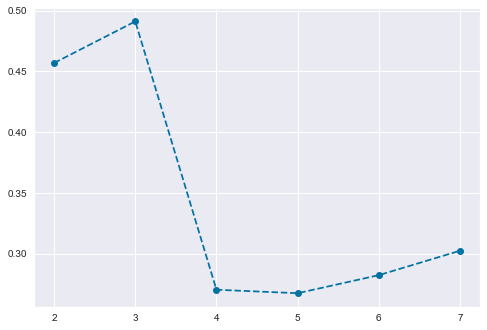

In [63]:
plt.plot( clusters,  hc_list, linestyle='--', marker='o', color='b' )

## 9.4 DBSCAN

In [64]:
eps=0.2
min_samples=20 

# model definition
dbscan_model = c.DBSCAN( eps=eps, min_samples=min_samples )

# mode training & predict 
labels = dbscan_model.fit_predict( X )

sil = m.silhouette_score( X, labels, metric='euclidean' )
print( 'Silhouette Score: {}'.format( sil ) )
print( 'Number of Clusters: {}'.format( len( np.unique( labels ) ) ) )
print( np.unique( labels ) )

Silhouette Score: 0.6063194089917986
Number of Clusters: 2
[-1  0]


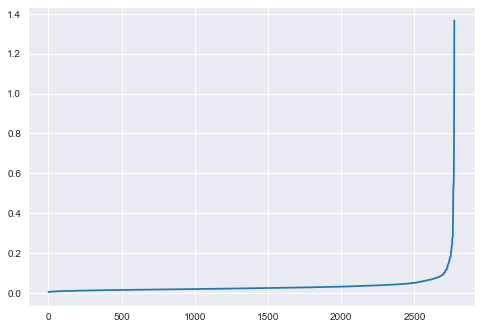

In [65]:
neighbors = NearestNeighbors( n_neighbors=min_samples ).fit( X )
distances, indices = neighbors.kneighbors( X )

distances = np.sort( distances, axis=0 )
distances = distances[:,1]
plt.plot( distances )

# plt.plot( distances[2000:] )

dbscan_list = [ 0.622034, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000]

## Results

In [66]:
# Model Name | k=2 | k=3 | k=4 | k=5 | ...
#  Kmeans      SS    SS    SS    SS
#  GMM         SS    SS    SS    SS
#  HC         SS     SS    SS    SS
#  DBSCAN     SS    SS    SS    SS

df_results = pd.DataFrame( 
    {'KMeans': kmeans_list, 
     'GMM': gmm_list, 
     'HC': hc_list, 
     'DBSCAN': dbscan_list
    }
).T

df_results.columns = clusters

In [67]:
df_results.style.highlight_max( color='lightgreen', axis=1 )

,2,3,4,5,6,7
KMeans,0.451210,0.488900,0.334136,0.330100,0.267498,0.342458
GMM,0.079453,0.022651,-0.020744,-0.069719,-0.057552,-0.076802
HC,0.457009,0.491183,0.270572,0.267707,0.282539,0.302629
DBSCAN,0.622034,0.000000,0.000000,0.000000,0.000000,0.000000


## 9.7 Silhouette code

In [ ]:
import matplotlib.cm as cm

fig, ax = plt.subplots( 3, 2 )
fig.set_size_inches( 25, 20 )

for k in clusters:
    q, mod = divmod( k, 2 )
    
    ax[q-1, mod].set_xlim( [ -0.1, 1] )
    ax[q-1, mod].set_ylim( [ 0, len( X ) + ( k+1 )*10] )
    
    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # performance
    ss = m.silhouette_score( X, labels, metric='euclidean' )
    print( ' For K = {}. Silhouette Score: {}'.format( k, ss ) )

    samples_silhouette_values = m.silhouette_samples( X, labels )

    y_lower = 10
    for i in range( k ):

        # select clusters
        ith_samples_silhouette_values = samples_silhouette_values[ labels == i]
        
        # sort values
        ith_samples_silhouette_values.sort()

        # size clusters
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap( 'Spectral' )
        color = cmap( i / k )

        ax[q-1, mod].fill_betweenx( np.arange( y_lower, y_upper ), 0, ith_samples_silhouette_values  )
        
        y_lower = y_upper + 10
        
    ax[q-1, mod].set_yticks([])
    ax[q-1, mod].set_xticks( [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 12 BUSINESS PERFORMANCE

Cluster 01: 
- Number of customers: 6 (0.14% of customers )
- Average Recency: 7 days
- Average invoice_no: 89 
- Average Gross Revenue: U\$182,182.00

Cluster 02:
- Number of customers: 28 (0.64% of customers )
- Average Recency: 6 days
- Average invoice_no: 58 
- Average Gross Revenue: U\$42,614.38 

Cluster 03:
- NNumber of customers: 4.071 (93% of customers )
- Average Recency: 97 days
- Average invoice_no: 3.6 
- Average Gross Revenue: U\$946.69 

Cluster 04:
- NNumber of customers: 267 (6.1% of customers )
- Average Recency: 20.3 days
- Average invoice_no: 19.5 
- Average Gross Revenue: U\$8,092.02 

## 12.1 Scenario: Cost to Reach 87% of Interested Customers

## 12.2 Scenario: Making only 20,000 calls

# 13 NEXT STEPS